In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# ignore futurewarnings, settingswithcopywarning
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

## This notebook is mainly used for determining the unknown distributions. So you may disregard the other parts. The analysis we conducted in R is more complete, but does make use of some results from this notebook.

In [25]:
# read in data ScanRecords.csv
df = pd.read_csv("ScanRecords.csv")
df.head(10)

,Date,Time,Duration,PatientType
0,2023-08-01,8.23,0.949176,Type 2
1,2023-08-01,8.49,0.479593,Type 1
2,2023-08-01,9.12,0.496112,Type 2
3,2023-08-01,10.26,0.691947,Type 2
4,2023-08-01,10.64,0.345412,Type 1
5,2023-08-01,11.07,0.422270,Type 1
6,2023-08-01,11.13,0.356129,Type 1
7,2023-08-01,11.33,0.688219,Type 2
8,2023-08-01,11.56,0.423303,Type 1
9,2023-08-01,11.89,0.690255,Type 2


In [26]:
# create df1 and df2 for the two different types of patients
df1 = df[df["PatientType"] == "Type 1"]
df2 = df[df["PatientType"] == "Type 2"]

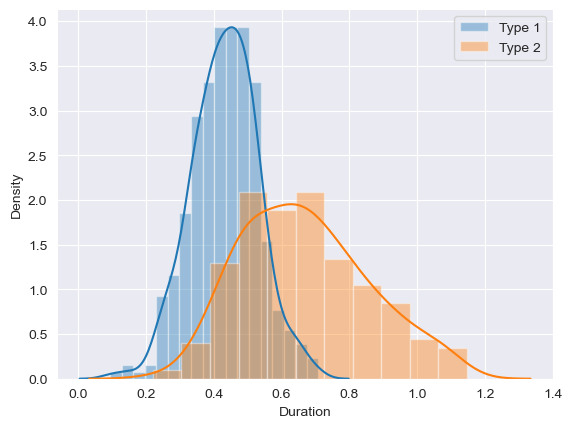

In [27]:
# plot the distribution of duration of the two types of patients
sns.distplot(df1["Duration"], label = "Type 1")
sns.distplot(df2["Duration"], label = "Type 2")
plt.legend()
plt.show()


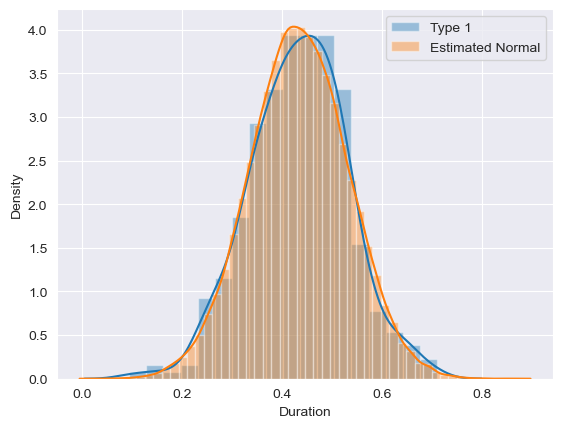

In [28]:
# get mean and std of df1
df1_mean = df1["Duration"].mean()
df1_std = df1["Duration"].std()

# plot df1 and a new normal distribution with df1_mean and df1_std
sns.distplot(df1["Duration"], label = "Type 1")
sns.distplot(np.random.normal(df1_mean, df1_std, 100000), label = "Estimated Normal")
plt.legend()
plt.show()


In [29]:
df1_mean, df1_std

(0.43266079748623376, 0.09777424259803229)

In [53]:
from sklearn.utils import resample


def bootstrap_mean_std(data, n_bootstrap=100_000):
    bootstrap_means = np.zeros(n_bootstrap)
    bootstrap_stds = np.zeros(n_bootstrap)


    for i in range(n_bootstrap):
        sample = resample(data)
        bootstrap_means[i] = sample.mean()
        bootstrap_stds[i] = sample.std()

    return bootstrap_means, bootstrap_stds

In [54]:
# Apply bootstrapping on the "duration" column of the DataFrame
bootstrap_means, bootstrap_stds = bootstrap_mean_std(df1["Duration"])

# 95% confidence
confidence_interval_mean = np.percentile(bootstrap_means, [2.5, 97.5])
confidence_interval_std = np.percentile(bootstrap_stds, [2.5, 97.5])

bootstrap_means.mean(), bootstrap_stds.mean(), confidence_interval_mean, confidence_interval_std


(0.4322029266535226,
 0.09686998434599993,
 array([0.42206145, 0.44230543]),
 array([0.08963778, 0.10419937]))

## Mean and std Type 1 Duration
Non bootstrapped:
    mean = 0.43266079748623376
    std  = 0.0977742425980323
Bootstrapped:
    mean = 0.4322029266535226
    std  = 0.09686998434599993


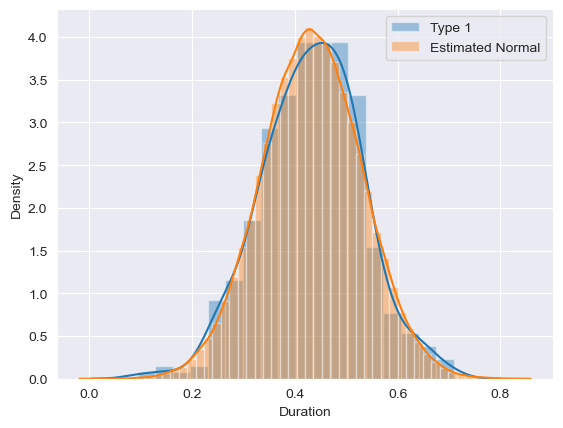

In [31]:
# plot df1 and a new normal distribution with df1_mean and df1_std
sns.distplot(df1["Duration"], label = "Type 1")
sns.distplot(np.random.normal(bootstrap_means.mean(), bootstrap_stds.mean(), 100_000), label = "Estimated Normal")
plt.legend()
plt.show()

In [32]:
# create a new column for the difference of the time of a row and the previous row
# be wary of the dates, on new days the time difference will be negative
df1["TimeDiff"] = df1["Time"].diff()
df2["TimeDiff"] = df2["Time"].diff()


In [33]:
# set all negative values to 0
df1["TimeDiff"] = df1["TimeDiff"].apply(lambda x: 0 if x < 0 else x)
df2["TimeDiff"] = df2["TimeDiff"].apply(lambda x: 0 if x < 0 else x)

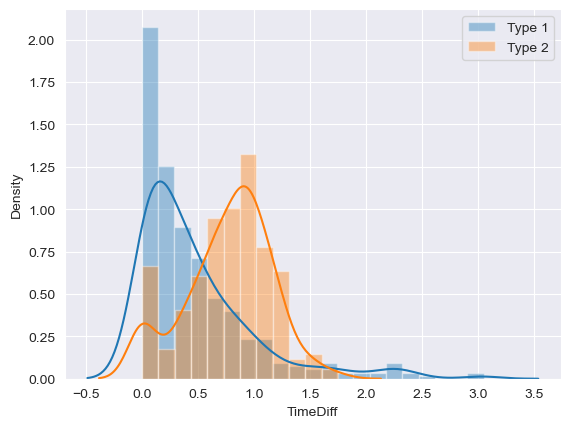

In [34]:
# plot the distribution of the time of the two types of patients
sns.distplot(df1["TimeDiff"], label = "Type 1")
sns.distplot(df2["TimeDiff"], label = "Type 2")
plt.legend()
plt.show()

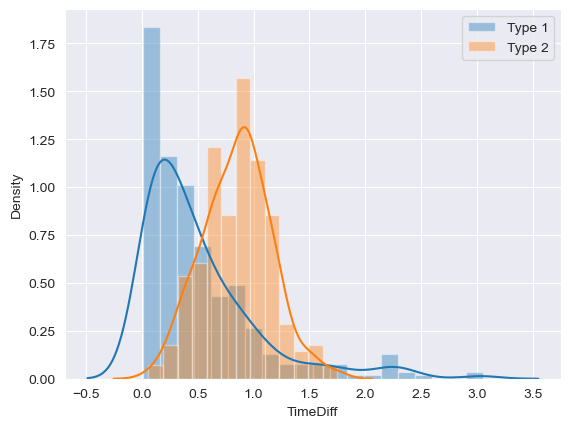

In [35]:
# same thing but dropping negative values
df1["TimeDiff"] = df1["Time"].diff()
df2["TimeDiff"] = df2["Time"].diff()

# drop negative rows
df1 = df1[df1["TimeDiff"] > 0]
df2 = df2[df2["TimeDiff"] > 0]


sns.distplot(df1["TimeDiff"][df1["TimeDiff"] > 0], label = "Type 1")
sns.distplot(df2["TimeDiff"][df2["TimeDiff"] > 0], label = "Type 2")
plt.legend()
plt.show()

In [59]:
estimated_lambda = df1["TimeDiff"].mean()

# poisson bootstrap
def bootstrap_poisson_lambda(data, n_bootstrap=1_000_000):
    bootstrap_lambdas = np.zeros(n_bootstrap)


    for i in range(n_bootstrap):
        sample = resample(data)
        bootstrap_lambdas[i] = sample.mean()

    return bootstrap_lambdas

In [60]:
# apply to timediff
bootstrap_lambdas = bootstrap_poisson_lambda(df1["TimeDiff"])

# 95% confidence
confidence_interval_lambda = np.percentile(bootstrap_lambdas, [2.5, 97.5])

estimated_lambda, bootstrap_lambdas.mean(), confidence_interval_lambda


(0.5150142450142451, 0.5150341147863248, array([0.46062678, 0.57242165]))

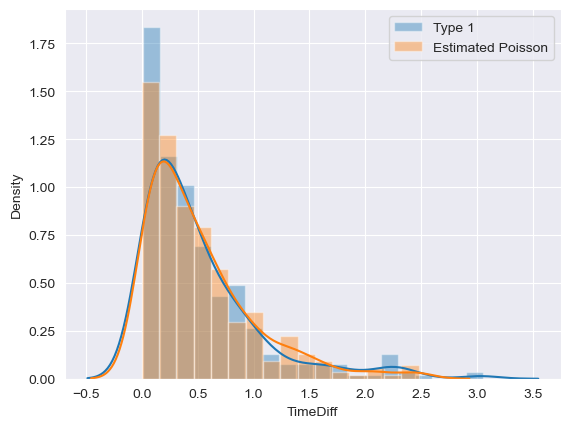

In [37]:
# plot df1 TimeDiff and a new poisson distribution with estimated_lambda
sns.distplot(df1["TimeDiff"], label = "Type 1")
sns.distplot(np.random.exponential(estimated_lambda, 351), label = "Estimated Poisson")
plt.legend()
plt.show()

In [39]:
import numpy as np
import pandas as pd
import scipy.stats as st
import warnings

# dists to check
DISTRIBUTIONS = [
    st.norm, st.gamma, st.expon, st.cauchy, st.lognorm, st.beta, st.uniform
]

def best_fit_distribution(data, bins=200, ax=None):

    # hist of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # best
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # estimate using MLE
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can"t be fit
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")

                # fit idst
                params = distribution.fit(data)

                # get params
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # calc PDF and error
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))


                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)



## Type 2 Duration = Gamma

In [40]:
# To use this function, you would pass your dataframe column to it like so:
data_column = df2["Duration"]  # or df2["TimeDiff"] for the other column
best_fit_name, best_fit_params = best_fit_distribution(data_column)
print(f"Best fit distribution for column is: {best_fit_name}")
print(f"Best fit parameters for column are: {best_fit_params}")

Best fit distribution for column is: gamma
Best fit parameters for column are: (14.767504836992813, -0.03816482525493267, 0.04792771454159874)


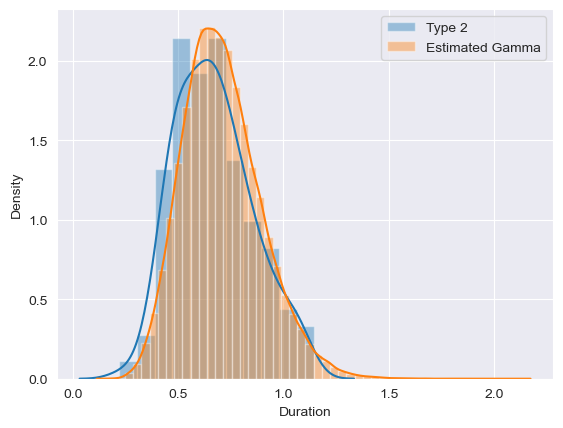

In [41]:
# plot df2 Duration and gamma distribution with best_fit_params
sns.distplot(df2["Duration"], label = "Type 2")
sns.distplot(np.random.gamma(best_fit_params[0], best_fit_params[2], 100000), label = "Estimated Gamma")
plt.legend()
plt.show()


## Type 2 arrival time = Normal

In [42]:
data_column = df2["TimeDiff"]  # or df2["TimeDiff"] for the other column
best_fit_name, best_fit_params = best_fit_distribution(data_column)
print(f"Best fit distribution for column is: {best_fit_name}")
print(f"Best fit parameters for column are: {best_fit_params}")

Best fit distribution for column is: norm
Best fit parameters for column are: (0.8515277777777778, 0.30425528262656815)


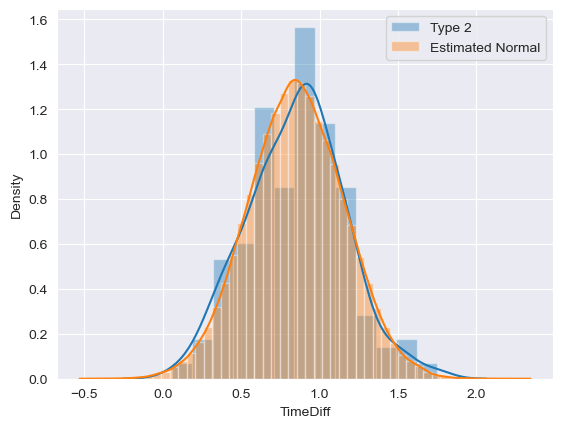

In [43]:
# plot df2 TimeDiff and normal distribution with best_fit_params
sns.distplot(df2["TimeDiff"], label = "Type 2")
sns.distplot(np.random.normal(best_fit_params[0], best_fit_params[1], 100000), label = "Estimated Normal")
plt.legend()
plt.show()
